# Project AV

## Fraud Detection System Using Data Visualization and Machine Learning

Norbert Tomàs Escudero (242695) Marc Sirvent Ruiz (240198)


The goal of this project is to build an integrated solution for detecting and preventing fraudulent financial transactions.

Our project focuses on answering the following questions:
- What trends and patterns are evident in transaction data, and how do they relate to fraudulent activity? (difference in trends and patterns from transaction data (non-fraudulent) and fraudulent)  
- Which features (e.g., transaction amount, card type, country) are the most important indicators of fraud? (Using SHAP on our predictive model of fraud) 
- How can we present insights and predictions in a user-friendly manner for decision-making? 

The results of this project will assist stakeholders in identifying fraud patterns through data-driven decisions.

https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets?select=train_fraud_labels.json

## Setup and data imports

In [1]:
#!pip install category_encoders
#!pip install lightgbm
#!pip install shap

import shap
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report, roc_curve, f1_score, balanced_accuracy_score, matthews_corrcoef
from category_encoders import TargetEncoder
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

c:\Users\nbtto\OneDrive\Documentos\Norbert\AV_PROJECT\frauddetection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
GLOBAL_PATH = './data/'
USERS_DATASET = "users_data.csv"
CARDS_DATASET = "cards_data.csv"
TRANSACTIONS_DATASET = "transactions_data.csv"
TRAIN_FRAUD_LABELS = "train_fraud_labels.json"
MCC_CODES_DATASET = "mcc_codes.json"

users_df = pd.read_csv(GLOBAL_PATH + USERS_DATASET)
cards_df = pd.read_csv(GLOBAL_PATH + CARDS_DATASET)
transactions_df = pd.read_csv(GLOBAL_PATH + TRANSACTIONS_DATASET)
train_fraud_labels_df = pd.read_json(GLOBAL_PATH + TRAIN_FRAUD_LABELS)
mcc_codes_df = pd.read_json(GLOBAL_PATH + MCC_CODES_DATASET, typ='series')

In [3]:
print("USERS_DATASET")
display(users_df.head())

print("\nCARDS_DATASET")
display(cards_df.head())

print("\nTRANSACTIONS_DATASET")
display(transactions_df.head())

print("\nTRAIN_FRAUD_LABELS")
display(train_fraud_labels_df.head())

print("\nMCC_CODES_DATASET")
display(mcc_codes_df.head())

USERS_DATASET


,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1



CARDS_DATASET


,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No



TRANSACTIONS_DATASET


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN



TRAIN_FRAUD_LABELS


,target
10649266,No
23410063,No
9316588,No
12478022,No
9558530,No



MCC_CODES_DATASET


5812           Eating Places and Restaurants
5541                        Service Stations
7996    Amusement Parks, Carnivals, Circuses
5411            Grocery Stores, Supermarkets
4784                   Tolls and Bridge Fees
dtype: object

## Data Cleaning

In [4]:
#Auxiliary functions
def remove_dollar(df, columns_to_clean):
    for column in columns_to_clean:
        df[column] = df[column].str.replace(r'[\$,]', '', regex=True)
        df[column] = pd.to_numeric(df[column])
    return df

In [5]:
# Users df
users_df_clean = users_df.copy()
users_df_clean = pd.get_dummies(users_df_clean, columns=['gender'], drop_first=True)
users_df_clean = remove_dollar(users_df_clean, ['per_capita_income', 'yearly_income', 'total_debt'])
users_df_clean = users_df_clean.drop(columns=['address'])

columns_to_rename = {'id': 'user_id'}
users_df_clean.rename(columns=columns_to_rename, inplace=True)

users_df_clean.head()

,user_id,current_age,retirement_age,birth_year,birth_month,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,gender_Male
0,825,53,66,1966,11,34.15,-117.76,29278,59696,127613,787,5,False
1,1746,53,68,1966,12,40.76,-73.74,37891,77254,191349,701,5,False
2,1718,81,67,1938,11,34.02,-117.89,22681,33483,196,698,5,False
3,708,63,63,1957,1,40.71,-73.99,163145,249925,202328,722,4,False
4,1164,43,70,1976,9,37.76,-122.44,53797,109687,183855,675,1,True


In [6]:
# Cards df
cards_df_clean = cards_df.copy()
cards_df_clean = remove_dollar(cards_df_clean, ['credit_limit'])

cards_df_clean['expires'] = pd.to_datetime(cards_df_clean['expires'], format="%m/%Y")
cards_df_clean['acct_open_date'] = pd.to_datetime(cards_df_clean['acct_open_date'], format="%m/%Y")
cards_df_clean['year_pin_last_changed'] = pd.to_datetime(cards_df_clean['year_pin_last_changed'], format="%Y")

cards_df_clean = pd.get_dummies(cards_df_clean, columns=['card_on_dark_web', 'has_chip', 'card_brand', 'card_type'], drop_first=True)

columns_to_rename = {'id': 'card_id', 'client_id': 'user_id', 'expires': 'card_expiration_date'}
cards_df_clean.rename(columns=columns_to_rename, inplace=True)

cards_df_clean.head()

,card_id,user_id,card_number,card_expiration_date,cvv,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,has_chip_YES,card_brand_Discover,card_brand_Mastercard,card_brand_Visa,card_type_Debit,card_type_Debit (Prepaid)
0,4524,825,4344676511950444,2022-12-01,623,2,24295,2002-09-01,2008-01-01,True,False,False,True,True,False
1,2731,825,4956965974959986,2020-12-01,393,2,21968,2014-04-01,2014-01-01,True,False,False,True,True,False
2,3701,825,4582313478255491,2024-02-01,719,2,46414,2003-07-01,2004-01-01,True,False,False,True,True,False
3,42,825,4879494103069057,2024-08-01,693,1,12400,2003-01-01,2012-01-01,False,False,False,True,False,False
4,4659,825,5722874738736011,2009-03-01,75,1,28,2008-09-01,2009-01-01,True,False,True,False,False,True


In [7]:
# Transactions df
transactions_df_clean = transactions_df.copy()

transactions_df_clean = remove_dollar(transactions_df_clean, ['amount'])
transactions_df_clean['date'] = pd.to_datetime(transactions_df_clean['date'], format="%Y-%m-%d %H:%M:%S")
transactions_df_clean = transactions_df_clean.drop(columns=['merchant_city', 'merchant_state', 'zip', 'errors']) # TODO: Dropped this columns because they have a lot of nulls
transactions_df_clean = pd.get_dummies(transactions_df_clean, columns=['use_chip'], drop_first=False)

columns_to_rename = {'id': 'transaction_id', 'date': 'transaction_date', 'client_id': 'user_id', 'amount': 'transaction_amount'}
transactions_df_clean.rename(columns=columns_to_rename, inplace=True)

transactions_df_clean.head()

,transaction_id,transaction_date,user_id,card_id,transaction_amount,merchant_id,mcc,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,59935,5499,False,False,True
1,7475328,2010-01-01 00:02:00,561,4575,14.57,67570,5311,False,False,True
2,7475329,2010-01-01 00:02:00,1129,102,80.00,27092,4829,False,False,True
3,7475331,2010-01-01 00:05:00,430,2860,200.00,27092,4829,False,False,True
4,7475332,2010-01-01 00:06:00,848,3915,46.41,13051,5813,False,False,True


In [8]:
# Train fraud labels df
train_fraud_labels_df_clean = train_fraud_labels_df.copy()
train_fraud_labels_df_clean = pd.get_dummies(train_fraud_labels_df_clean, columns=['target'], drop_first=True)
train_fraud_labels_df_clean = train_fraud_labels_df_clean.reset_index()
train_fraud_labels_df_clean.columns = ['transaction_id', 'target_Yes'] #From json -> df

train_fraud_labels_df_clean.head()

,transaction_id,target_Yes
0,10649266,False
1,23410063,False
2,9316588,False
3,12478022,False
4,9558530,False


In [9]:
# Mcc codes
mcc_codes_df_clean = mcc_codes_df.copy()
mcc_codes_df_clean = mcc_codes_df_clean.reset_index()
mcc_codes_df_clean.columns = ['mcc', 'mcc_description']

mcc_codes_df_clean.head()

,mcc,mcc_description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees


In [10]:
#Dataset joining:
transaction_users = pd.merge(transactions_df_clean, users_df_clean, on='user_id', how='inner')
transcation_card = pd.merge(transaction_users, cards_df_clean, on='card_id', how='inner')
train_df = pd.merge(transcation_card, train_fraud_labels_df_clean, on='transaction_id', how='inner')

train_df.head(1)

,transaction_id,transaction_date,user_id_x,card_id,transaction_amount,merchant_id,mcc,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,...,credit_limit,acct_open_date,year_pin_last_changed,has_chip_YES,card_brand_Discover,card_brand_Mastercard,card_brand_Visa,card_type_Debit,card_type_Debit (Prepaid),target_Yes
0,7475327,2010-01-01 00:01:00,1556,2972,-77.0,59935,5499,False,False,True,...,55,2008-05-01,2008-01-01,True,False,True,False,False,True,False


## Correlation Analysis of Features and Fraud


Its also important to check whether the dataset contains nulls or not and decide whether to drop or impute the values.


Luckily we have no null values so we don't need to do any further transformations

In [11]:
train_df.isnull().sum()

transaction_id                 0
transaction_date               0
user_id_x                      0
card_id                        0
transaction_amount             0
merchant_id                    0
mcc                            0
use_chip_Chip Transaction      0
use_chip_Online Transaction    0
use_chip_Swipe Transaction     0
current_age                    0
retirement_age                 0
birth_year                     0
birth_month                    0
latitude                       0
longitude                      0
per_capita_income              0
yearly_income                  0
total_debt                     0
credit_score                   0
num_credit_cards               0
gender_Male                    0
user_id_y                      0
card_number                    0
card_expiration_date           0
cvv                            0
num_cards_issued               0
credit_limit                   0
acct_open_date                 0
year_pin_last_changed          0
has_chip_Y

We will also handle boolean values in our dataset so its easier for our model to train.

In [12]:
bool_cols = train_df.select_dtypes(include=[bool]).columns
for col in bool_cols:
    train_df[col] = train_df[col].astype(int)

We will also handle the datetime features and create individual columns for each unit of time.

In [13]:
# Extracting time features from transaction_date
train_df['transaction_year'] = train_df['transaction_date'].dt.year
train_df['transaction_month'] = train_df['transaction_date'].dt.month
train_df['transaction_day'] = train_df['transaction_date'].dt.day
train_df['transaction_dayofweek'] = train_df['transaction_date'].dt.dayofweek
train_df['transaction_hour'] = train_df['transaction_date'].dt.hour

# Time since account opening
train_df['days_since_acct_open'] = (train_df['transaction_date'] - train_df['acct_open_date']).dt.days
train_df['days_since_pin_change'] = (train_df['transaction_date'] - train_df['year_pin_last_changed']).dt.days

## Training

As our training data is really unbalanced we need to downsample the False values in the target variable to be equiparable with the True values.

In [15]:
# Count the positives (True)
true_count = (train_df['target_Yes'] == True).sum()

# Get all True samples
true_df = train_df[train_df['target_Yes'] == True]

ratio = 5  # 1:5 , True:False
false_df = train_df[train_df['target_Yes'] == False].sample(n=true_count * ratio, random_state=42)
train_df_sample = pd.concat([true_df, false_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

print("Shape of the training data: ", false_df.shape[0])
print("\nNumber of true values: ", true_count)

Shape of the training data:  66660

Number of true values:  13332


In [16]:
#Analysis of correlation of the sampled df with other features
corr = train_df_sample.corr()['target_Yes'].sort_values(ascending=False)

print("Correlation values:\n", corr)

Correlation values:
 target_Yes                     1.000000
use_chip_Online Transaction    0.498417
transaction_amount             0.214287
num_credit_cards               0.065718
merchant_id                    0.056435
card_type_Debit (Prepaid)      0.048113
current_age                    0.041753
transaction_dayofweek          0.038592
card_brand_Discover            0.023356
transaction_month              0.018843
has_chip_YES                   0.013028
retirement_age                 0.006755
transaction_day                0.006701
transaction_id                 0.006437
credit_score                   0.005878
transaction_date               0.005195
acct_open_date                 0.004635
transaction_year               0.003270
days_since_pin_change          0.003170
cvv                            0.002540
year_pin_last_changed          0.000925
days_since_acct_open          -0.000868
num_cards_issued              -0.002178
card_number                   -0.004088
user_id_x          

We observe how the columns use_chip_""_ Transaction seem to be related with the target_Yes column, same for the mcc, merchant_id etc. We will observe later if our starting assumptions are correct.

After the exploration of the correlations between the target variable and the other features we will start by creating a preliminar model.

In [17]:
# Define feature set and target

columns_to_drop = ['target_Yes', 'transaction_id', 'transaction_date', 'acct_open_date', 'year_pin_last_changed', 'card_expiration_date', 'mcc_description']

features = [col for col in train_df.columns if col not in columns_to_drop]

target = 'target_Yes'

X_sample = train_df_sample[features].select_dtypes(include=[np.number])
y_sample = train_df_sample[target]

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

model = LGBMClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc')

# Feature importances
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nFeature importance: ", feature_importances.head(50))  # top 50 features

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8533, number of negative: 42661
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4469
[LightGBM] [Info] Number of data points in the train set: 51194, number of used features: 38
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Feature importance:  mcc                            709
merchant_id                    420
transaction_year               355
transaction_amount             240
transaction_hour               233
transaction_month               95
transaction_dayofweek           78
use_chip_Online 

We will convert certain columns into another data type for optimization purposes

In [18]:
float_cols = train_df.select_dtypes(include=['float64']).columns
int_cols = train_df.select_dtypes(include=['int64']).columns

train_df[float_cols] = train_df[float_cols].astype('float32')
train_df[int_cols] = train_df[int_cols].astype('int32')

After idenitying the most important features we will train the model with the whole dataset selecting the top features identified earlier.

In [19]:
top_features = feature_importances.head(10).index.tolist()  # Get top 10 most important features for training the model

X = train_df[top_features]
y = train_df[target]

X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(X, y, test_size=0.2, 
                                                                      random_state=42, stratify=y)

final_model = LGBMClassifier(n_estimators=1000, random_state=42, class_weight='balanced')
final_model.fit(X_train_full, y_train_full, eval_set=[(X_val_full, y_val_full)], eval_metric='auc')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 10666, number of negative: 7121304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1184
[LightGBM] [Info] Number of data points in the train set: 7131970, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', n_estimators=1000, random_state=42)

## Model analysis of metrics and results

In [20]:
#We now should study the main metrics of the model.
y_pred_proba = final_model.predict_proba(X_val_full)[:,1]
val_auc = roc_auc_score(y_val_full, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_val_full, y_pred_proba)
pr_auc = auc(recall, precision)

print("Validation AUC:", val_auc)
print("Precision-Recall AUC:", pr_auc)

Validation AUC: 0.995340998093765
Precision-Recall AUC: 0.8012526837978332


In [21]:
top_features = feature_importances.head(10).index.tolist()  # Get top 10 most important features

cols = top_features + [target] 
train_df_sample = train_df_sample[cols]
train_df_sample.head()

,mcc,merchant_id,transaction_year,transaction_amount,transaction_hour,transaction_month,transaction_dayofweek,use_chip_Online Transaction,per_capita_income,longitude,target_Yes
0,5300,97333,2014,100.78,8,1,3,0,20294,-76.14,0
1,4900,13574,2018,16.46,15,3,5,0,16537,-122.62,0
2,4784,96246,2012,68.97,6,5,5,1,39789,-87.68,0
3,5499,59935,2016,22.16,12,1,6,0,15838,-80.61,0
4,5311,81477,2010,164.49,7,5,3,1,15296,-124.04,1


We observe a pretty good validation AUC and a nice Precision-Recall AUC

In [22]:
y_pred = (y_pred_proba >= 0.5).astype(int)
cm = confusion_matrix(y_val_full, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1768068   12259]
 [    252    2414]]


At a threshold of 0.5 we obtained: 

TN (True Negatives): 1,768,068 legitimate (non-fraud) transactions correctly classified as non-fraud.
FP (False Positives): 12,259 legitimate transactions incorrectly classified as fraud.
FN (False Negatives): 252 fraudulent transactions incorrectly classified as non-fraud.
TP (True Positives): 2,414 fraudulent transactions correctly classified as fraud.


In [23]:
print("Classification Report:")
print(classification_report(y_val_full, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1780327
           1       0.16      0.91      0.28      2666

    accuracy                           0.99   1782993
   macro avg       0.58      0.95      0.64   1782993
weighted avg       1.00      0.99      1.00   1782993



From the classification report we observe mainly that for the class 1 (fraud) the model catches the majority of actual fraud cases, missing only about 9.1% of them.
While recall is excellent, precision is quite low. Only about 16.5% of transactions flagged as fraud are actually fraudulent. This indicates a high rate of false alarms—many legitimate transactions are being incorrectly identified as fraud. But this is not something we are the worried about as for our purposes we prefer to flag a transaction as fraudulent rather than not detecting it. Still we will need to consider some improvements for it as it could lead to unnecessary investigations, higher operational costs, and potential customer dissatisfaction due to flagged legitimate purchases.

In [24]:
# Run this code if necessary to download the datasets and model for the streamlit app

""" import pickle 

data = {"model": final_model}

with open('final_model.pkl', 'wb') as file:
    pickle.dump(data, file)

train_df_sample.to_csv("train_df_sample.csv", index=False) """

' import pickle \n\ndata = {"model": final_model}\n\nwith open(\'final_model.pkl\', \'wb\') as file:\n    pickle.dump(data, file)\n\ntrain_df_sample.to_csv("train_df_sample.csv", index=False) '

## SHAP analysis


c:\Users\nbtto\OneDrive\Documentos\Norbert\AV_PROJECT\frauddetection\.venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


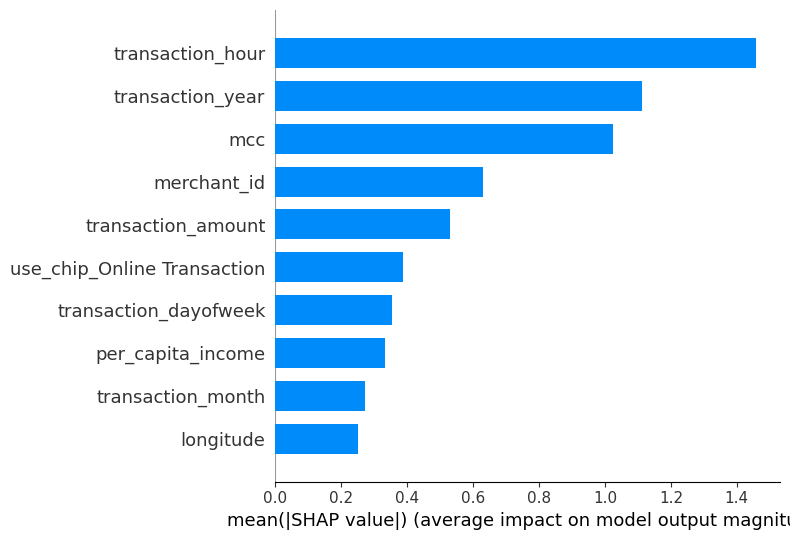

In [25]:
#First SHAP values testing: 
sample_for_shap = X_val_full.sample(1000, random_state=42)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(sample_for_shap)

# Summary plot
shap.summary_plot(shap_values, sample_for_shap, plot_type="bar")

We observe in the plot what are the different impacts in the model output of various features. 

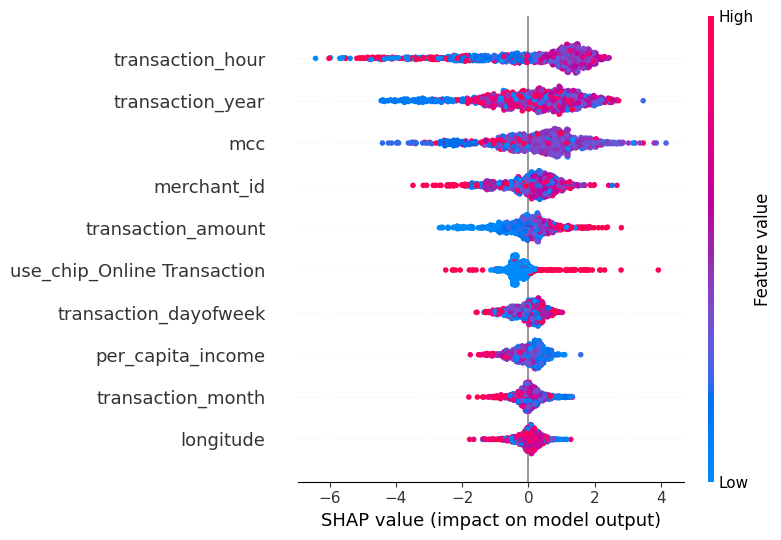

In [26]:
shap.summary_plot(shap_values, sample_for_shap)  

This visualization mixes the different ranges of values that the features can take and their impact on the model output.
We can observe 3 interesting features, transaction_hour, mcc and transaction_amount, we also could consider the transaction_year but is not relevant in this case because of how the df is constructed where only 2 years are considered [2010] (low information). 
We will observe them individually for further analysis.

To understand how a single feature’s value influences predictions in conjunction with another feature we will use a dependence plot using the principal features that had more impact on the model output:

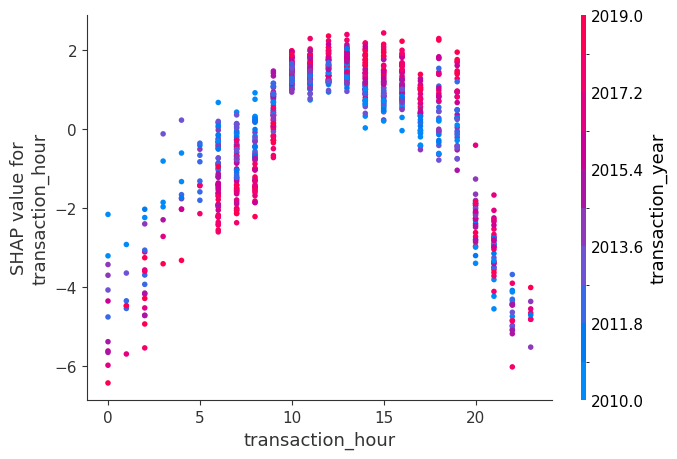

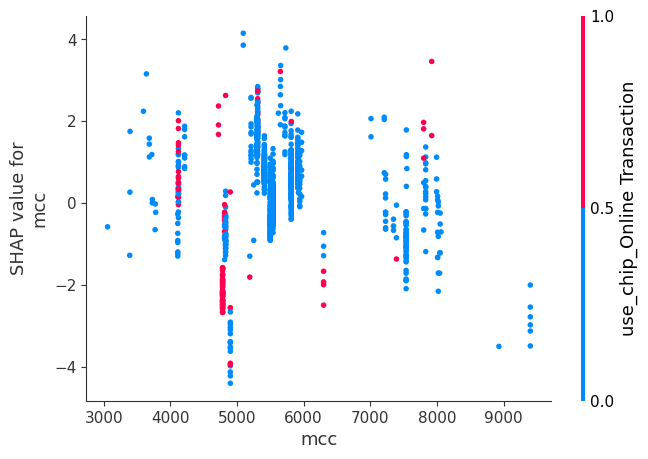

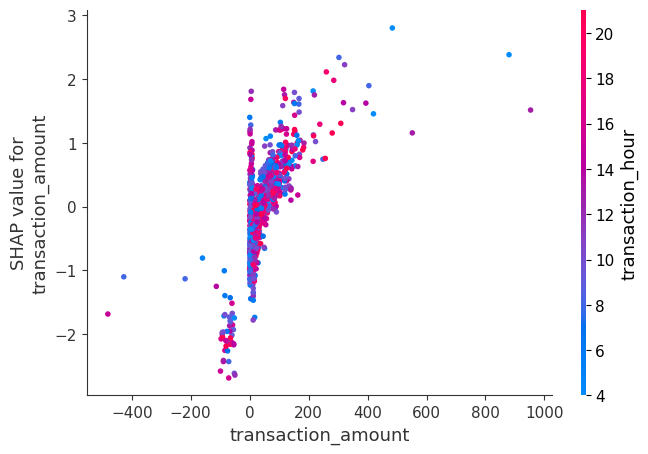

In [27]:
features = ["transaction_hour", "mcc", "transaction_amount"]
for i in features:
    shap.dependence_plot(i, shap_values, sample_for_shap)


Transaction_hour vs. SHAP value:
    We observe that mid-range hours (e.g., around midday) might show higher or lower SHAP values, suggesting that certain hours increase the likelihood of fraud. The color encoding reveals that this hour-based pattern evolves over time. 

Mcc vs. SHAP value:
    The mcc plot shows how certain categories are associated with positive or negative contributions to fraud likelihood. The second color dimension shows that within certain MCC ranges, higher transaction amounts push predictions in a particular direction.

Transaction_amount vs. SHAP value:
    By plotting SHAP values against transaction_amount and coloring by transaction_hour, we might see that large transaction amounts during particular hours have a stronger influence on the fraud prediction. Lower amounts may cluster around zero SHAP impact, while extreme values (either very high or unusual amounts) create strong positive or negative pushes in the model’s output.

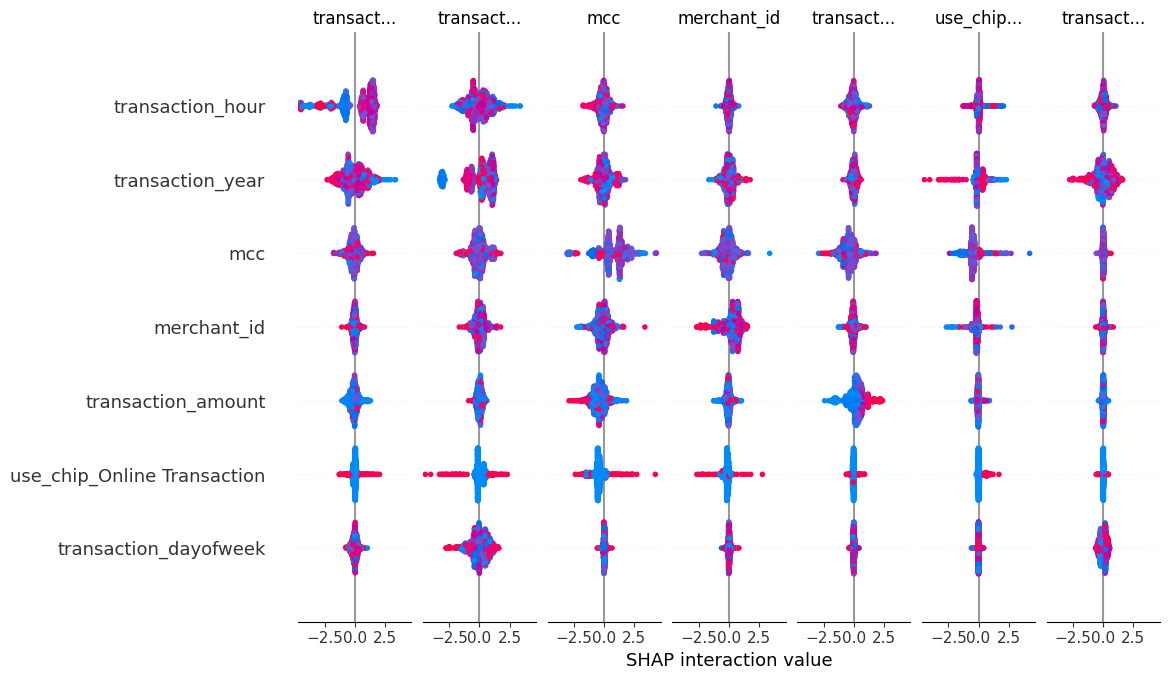

In [28]:
# Compute interaction values 
shap_interaction_values = explainer.shap_interaction_values(sample_for_shap)

shap.summary_plot(shap_interaction_values, sample_for_shap)

On this interaction plot we observe how pairs of features jointly affect the prediction.

In [29]:
# Take an individual instance from sample_for_shap

shap.initjs()
single_instance = sample_for_shap.iloc[[0]]
single_shap_value = explainer.shap_values(single_instance)
shap.force_plot(explainer.expected_value, single_shap_value, single_instance)

c:\Users\nbtto\OneDrive\Documentos\Norbert\AV_PROJECT\frauddetection\.venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


This plot is made in case you want to analyze the specific values that lead to a certain prediction. 

## Plots and EDA

In [30]:
transactions_with_labels = pd.merge(transactions_df_clean, train_fraud_labels_df_clean, on='transaction_id', how='inner')
transactions_with_labels.head()

,transaction_id,transaction_date,user_id,card_id,transaction_amount,merchant_id,mcc,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,target_Yes
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,59935,5499,False,False,True,False
1,7475328,2010-01-01 00:02:00,561,4575,14.57,67570,5311,False,False,True,False
2,7475329,2010-01-01 00:02:00,1129,102,80.00,27092,4829,False,False,True,False
3,7475332,2010-01-01 00:06:00,848,3915,46.41,13051,5813,False,False,True,False
4,7475333,2010-01-01 00:07:00,1807,165,4.81,20519,5942,False,False,True,False


In [31]:
#transactions_with_labels.to_csv("transactions_with_labels.csv", index=False)
#users_df_clean.to_csv("users_df_clean.csv", index=False)
#cards_df_clean.to_csv("cards_df_clean.csv", index=False)
#transactions_df_clean.to_csv("transactions_df_clean.csv", index=False)
#train_fraud_labels_df_clean.to_csv("train_fraud_labels_df_clean.csv", index=False)
#mcc_codes_df_clean.to_csv("mcc_codes_df_clean.csv", index=False)

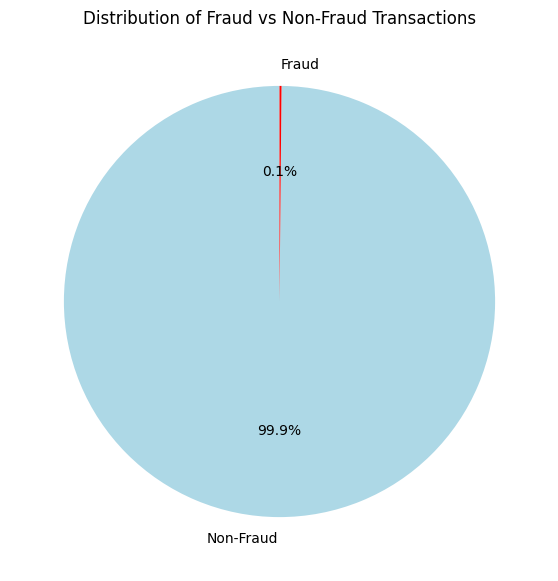

In [32]:
transaction_counts = transactions_with_labels['target_Yes'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(transaction_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'red'])
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.show()

In [33]:
transactions_with_labels['target_Yes'].value_counts()

target_Yes
False    8901631
True       13332
Name: count, dtype: int64

The bar charts helps understand the balance between the fraudulent and non-fraudulent transactions. As we can see the dataset is imbalanced, we have a lot non-fraudulent than fraudulent transactions.

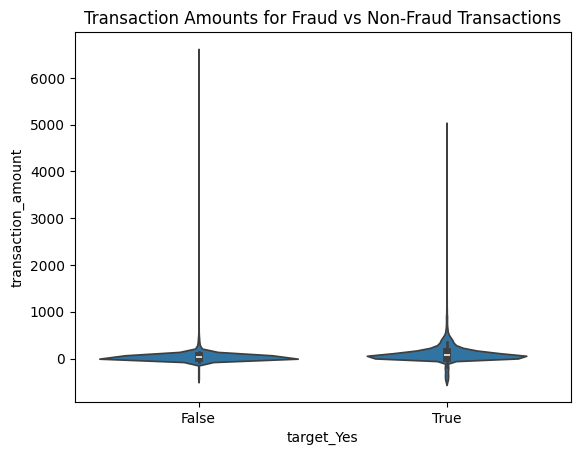

In [34]:
sns.violinplot(x='target_Yes', y='transaction_amount', data=transactions_with_labels)
plt.title('Transaction Amounts for Fraud vs Non-Fraud Transactions')
plt.show()

In [35]:
Q1 = transactions_with_labels['transaction_amount'].quantile(0.25)
Q3 = transactions_with_labels['transaction_amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_transactions = transactions_with_labels[(transactions_with_labels['transaction_amount'] >= lower_bound) & (transactions_with_labels['transaction_amount'] <= upper_bound)]

mean_transaction_amount_by_target = filtered_transactions.groupby('target_Yes')['transaction_amount'].mean()
print(mean_transaction_amount_by_target)

target_Yes
False    36.505369
True     52.609959
Name: transaction_amount, dtype: float64


This plot has the purpose to analyze the spending patterns of fraudulent and non-fraudulent transactions. We can see that in terms of outliers in the spending patterns we cannot extract conclusions. However, if we compute the mean (without outliers) we can see that the transactions that are fraudulent have a higher mean.

In [36]:
transactions_with_labels_mcc = transactions_with_labels.merge(mcc_codes_df_clean, on='mcc', how='left')
transactions_with_labels_mcc.head()

,transaction_id,transaction_date,user_id,card_id,transaction_amount,merchant_id,mcc,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,target_Yes,mcc_description
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,59935,5499,False,False,True,False,Miscellaneous Food Stores
1,7475328,2010-01-01 00:02:00,561,4575,14.57,67570,5311,False,False,True,False,Department Stores
2,7475329,2010-01-01 00:02:00,1129,102,80.00,27092,4829,False,False,True,False,Money Transfer
3,7475332,2010-01-01 00:06:00,848,3915,46.41,13051,5813,False,False,True,False,Drinking Places (Alcoholic Beverages)
4,7475333,2010-01-01 00:07:00,1807,165,4.81,20519,5942,False,False,True,False,Book Stores


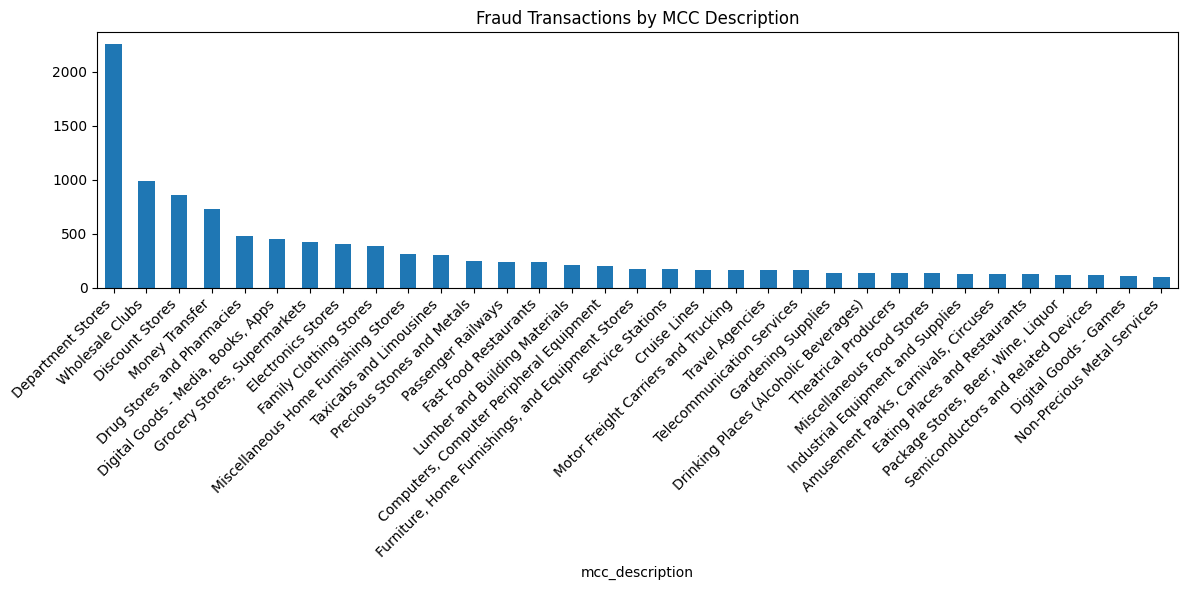

In [37]:
fraud_by_region = transactions_with_labels_mcc[transactions_with_labels_mcc['target_Yes'] == 1] \
    .groupby('mcc_description')['target_Yes'].count() \
    .sort_values(ascending=False)

min_fraud_threshold = 100
fraud_by_region_filtered = fraud_by_region[fraud_by_region >= min_fraud_threshold]

plt.figure(figsize=(12, 6))
fraud_by_region_filtered.plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.title('Fraud Transactions by MCC Description')
plt.tight_layout() 
plt.show()

In the graph above we can see the number of fraud (>100 frauds commited) classified by type of bussiness. We can see that the most typical fraud bussiness place are Department Stores.

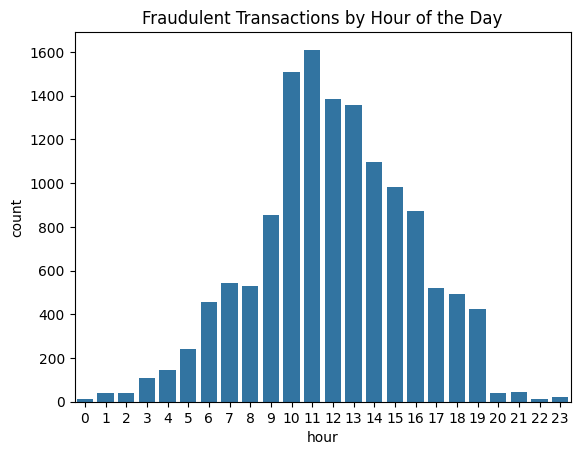

In [38]:
fraud_transactions = transactions_with_labels[transactions_with_labels['target_Yes'] == 1].copy()
fraud_transactions['hour'] = fraud_transactions['transaction_date'].dt.hour

sns.countplot(x='hour', data=fraud_transactions)
plt.title('Fraudulent Transactions by Hour of the Day')
plt.show()

In the plot above we can see that the hour that most fraudulent transactions take place is between 10 and 13.

In [39]:
correlation_df = transactions_with_labels.merge(users_df_clean, on='user_id', how='left')
correlation_df = correlation_df.merge(cards_df_clean, on='card_id', how='left')
correlation_df = correlation_df.drop(columns=['transaction_id', 'user_id_x', 'user_id_y', 'card_id', 'birth_year', 'birth_month', 'latitude', 'longitude'])

correlation_df.head()

,transaction_date,transaction_amount,merchant_id,mcc,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,target_Yes,current_age,retirement_age,...,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,has_chip_YES,card_brand_Discover,card_brand_Mastercard,card_brand_Visa,card_type_Debit,card_type_Debit (Prepaid)
0,2010-01-01 00:01:00,-77.00,59935,5499,False,False,True,False,30,67,...,2,55,2008-05-01,2008-01-01,True,False,True,False,False,True
1,2010-01-01 00:02:00,14.57,67570,5311,False,False,True,False,48,67,...,1,9100,2005-09-01,2015-01-01,True,False,True,False,False,False
2,2010-01-01 00:02:00,80.00,27092,4829,False,False,True,False,49,65,...,1,14802,2006-01-01,2008-01-01,True,False,True,False,True,False
3,2010-01-01 00:06:00,46.41,13051,5813,False,False,True,False,51,69,...,1,19113,2009-07-01,2014-01-01,True,False,False,True,True,False
4,2010-01-01 00:07:00,4.81,20519,5942,False,False,True,False,47,65,...,1,89,2008-01-01,2015-01-01,True,False,True,False,False,True


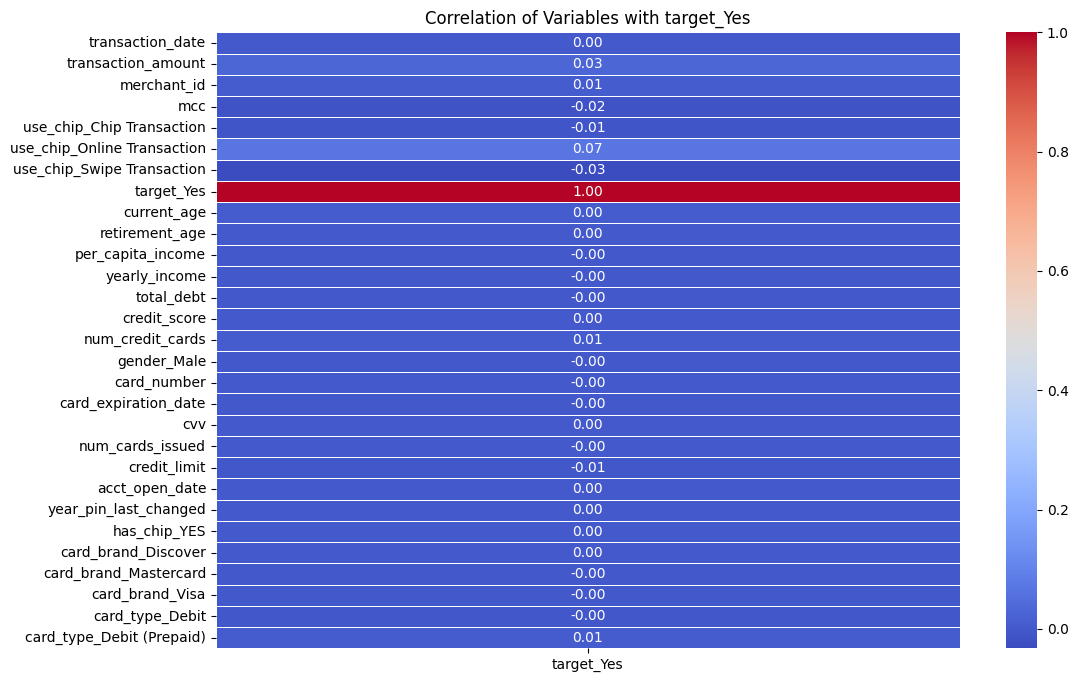

In [40]:
correlation_with_target = correlation_df.corr()['target_Yes'].drop('target_Yes')  # Drop the self-correlation with target_Yes

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(correlation_df.corr()[['target_Yes']], annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, ax=ax)
plt.title("Correlation of Variables with target_Yes")
plt.show()